# Monte-Carlo methods

Notation
- Random properties of the system $X_i$ (loading, strength, ...)
- We know the distributio of each $X_i$ described by PDF $f_{X_i}(x)$ or CDF $F_{X_i}(x)$ 
- Performace function $g(X_1, X_2, \cdots, X_n)$
- Failure occurs when $Z = g(X_1, X_2, \cdots, X_n) \leq 0$

Steps common to all Monte-Carlo methods
- Generate random samples of input values
- Transform the inputs into desired output deterministically (e.g. evaluate $g(x_1, x_2, \cdots, x_n)$)
- Analyze the results (e.g. calculate mean values $E[Z]$ or probability of failure $p_f$)

## Sampling methods

- direct (naive) sampling
- rejection sampling (accept-reject algorithm)
- Latin hypercube sampling
- Markov chain Monte-Carlo sampling methods
  - Metropolis-Hastings algorithm
  - Gibbs sampling
  - Hamiltonian MC
  - No U-turn sampler (NUTS)

## Direct sampling

We have to be able to evaluate inverse CDF $F_X^{-1}(a)$.

1. generate samples $a_j$ from uniform distribution $\mathcal{U}(0,1)$
2. transorm the samples $a_j$ to gen samples with desired distribution $x_j = F_X^{-1}(a_j)$
3. Optional: plot histogram and calcuclate statistics of $x_j$ to check their distribution

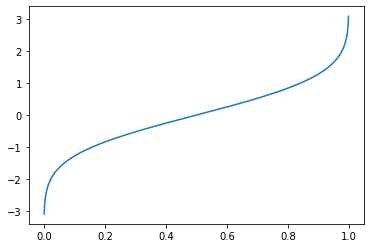

In [16]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Inverse CDF of our distribution
# We borrow inverse normal CDF from scipy.stats package
def F_inv(a):
    return stats.norm.ppf(a)

a_arr = np.linspace(0.001, 0.999, 1000)
#print(a_arr)
x_arr = [F_inv(a) for a in a_arr]

plt.plot(a_arr, x_arr)

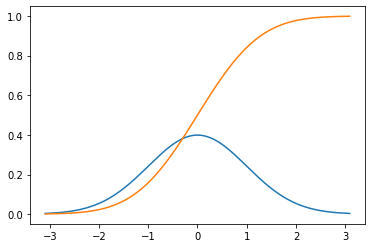

In [2]:
# Just recall PDF and CDF
plt.plot(x_arr, stats.norm.pdf(x_arr))
plt.plot(x_arr, stats.norm.cdf(x_arr))

(array([ 967., 1025., 1021., 1042.,  983., 1021.,  999.,  964.,  992.,
         986.]),
 array([9.29597558e-06, 9.99976330e-02, 1.99985970e-01, 2.99974307e-01,
        3.99962644e-01, 4.99950981e-01, 5.99939318e-01, 6.99927655e-01,
        7.99915993e-01, 8.99904330e-01, 9.99892667e-01]),
 <a list of 10 Patch objects>)

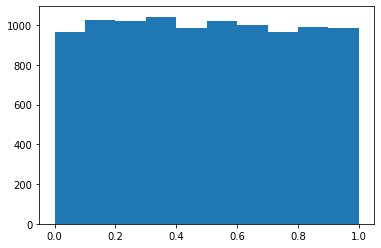

In [19]:
# Generate samples between 0 and 1 from uniform distiribution
num_samples = 10000 # try up to 10000
a_samples = np.random.rand(num_samples)
#print(a_samples)
plt.hist(a_samples)

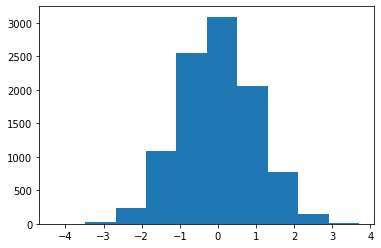

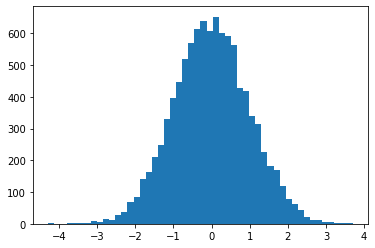

In [20]:
x_samples = [F_inv(a) for a in a_samples]
plt.hist(x_samples)
plt.show()
plt.hist(x_samples, bins=50)
plt.show()

## Rejection sampling

We have to
- be able to evaluate the _target_ PDF $f_X(x)$
- choose suitable _proposal_ distribution (with PDF $g_X(x)$) from which it is easy to sample
- find number $M$ so that the scaled $Mg(x)>f(x)$ for each $x$

Algorithm
1. sample point $x$ from proposal distribution
- sample $a$ from $\mathcal{U}(0, Mg(x))$
- if $a>f(x)$ reject the sample
- else accept the sample (add it to the list of the generated samples)
- repeat until you have enought samples (or get bored)

## Latin hypercube sampling (stratification method)
Motivation (think of the direct sampling method described earlier)
- If we want just a handfull of uniformly distributed samples should'n are realy uniformy distributed?
- If yes, how to handle multidimensional domain?

Latin square: there is exactly one element in each column and each row.

Latin hypercube: there is exactly one element in each strata.



[[0. 0.]
 [1. 1.]
 [2. 2.]
 [3. 3.]
 [4. 4.]
 [5. 5.]
 [6. 6.]
 [7. 7.]
 [8. 8.]
 [9. 9.]]
SpearmanrResult(correlation=0.9999999999999999, pvalue=6.646897422032013e-64)


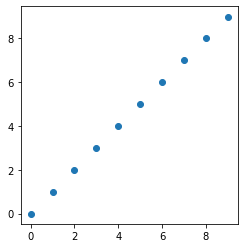

In [48]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
np.random.seed(42)

dim = 2
num_samples = 10

a = np.empty([num_samples, dim])

a[:,0] = np.arange(num_samples)
a[:,1] = np.arange(num_samples)

r = stats.spearmanr(a[:,0],a[:,1])
print(a)
print(r)
plt.scatter(a[:,0], a[:,1])
plt.axis('scaled')
plt.show()

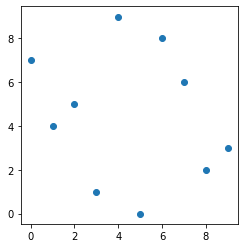

In [53]:
np.random.shuffle(a[:,1])
r = stats.spearmanr(a[:,0],a[:,1])
#print(a)
#print(r)
plt.scatter(a[:,0], a[:,1])
plt.axis('scaled')
plt.show()

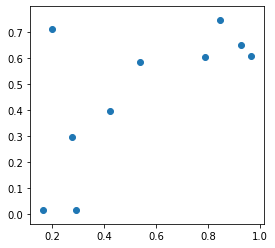

In [54]:
# Compare by true runiform
tu = np.random.rand(num_samples, 2)
plt.scatter(tu[:,0], tu[:,1])
plt.axis('scaled')
plt.show()

## Correlated variables

Spearman's rank correlation coefficient between samples $x_i$ and $y_i$, $i=1\cdots n$.
$$
r_s = 1 - \frac{6 \sum (r_{x,i}-r_{y,i})^2}{n(n^2 - 1)}
$$

In [40]:
# current spearman correlation matrix

R = np.array([[1,r.correlation],[r.correlation,1]])
print(f"r = {r}")
print(f"R = {R}")

# requested spearman correlation matrix
rho = -0.8
corr_matrix = np.array([[1,rho],[rho,1]])
L = np.linalg.cholesky(corr_matrix)
print(corr_matrix)
print(L)
print(L.transpose())
print(L.dot(L.transpose()))

r = SpearmanrResult(correlation=0.9518796992481202, pvalue=1.1028078978991561e-10)
R = [[1.        0.9518797]
 [0.9518797 1.       ]]
[[ 1.  -0.8]
 [-0.8  1. ]]
[[ 1.   0. ]
 [-0.8  0.6]]
[[ 1.  -0.8]
 [ 0.   0.6]]
[[ 1.  -0.8]
 [-0.8  1. ]]


In [41]:
num_iter = 3
for i in range(num_iter):
    print(f"i = {i}")
    temp = a.dot(L)
    print(f"temp = {temp}")
    for i in range(dim):
        a[:,i] = temp[:,i].argsort().argsort()
    print(f"a = {a}")
    r = stats.spearmanr(a[:,0],a[:,1])
    print(f"r = {r.correlation}")

i = 0
temp = [[ 2.8 11.4]
 [-0.6  4.2]
 [-0.6 10.2]
 [-0.8  0.6]
 [-1.2  2.4]
 [ 0.4  7.2]
 [ 1.2  9.6]
 [ 4.6 10.8]
 [ 1.   0. ]
 [ 1.   6. ]
 [ 0.6  1.8]
 [ 1.2  3.6]
 [ 3.8  8.4]
 [ 5.   9. ]
 [ 3.2  6.6]
 [ 5.6  7.8]
 [ 3.   3. ]
 [ 1.6  4.8]
 [ 3.8  5.4]
 [ 2.4  1.2]]
a = [[12. 19.]
 [ 3.  7.]
 [ 2. 17.]
 [ 1.  1.]
 [ 0.  4.]
 [ 4. 12.]
 [ 8. 16.]
 [17. 18.]
 [ 7.  0.]
 [ 6. 10.]
 [ 5.  3.]
 [ 9.  6.]
 [15. 14.]
 [18. 15.]
 [14. 11.]
 [19. 13.]
 [13.  5.]
 [10.  8.]
 [16.  9.]
 [11.  2.]]
r = 0.4240601503759398
i = 1
temp = [[ -3.2  11.4]
 [ -2.6   4.2]
 [-11.6  10.2]
 [  0.2   0.6]
 [ -3.2   2.4]
 [ -5.6   7.2]
 [ -4.8   9.6]
 [  2.6  10.8]
 [  7.    0. ]
 [ -2.    6. ]
 [  2.6   1.8]
 [  4.2   3.6]
 [  3.8   8.4]
 [  6.    9. ]
 [  5.2   6.6]
 [  8.6   7.8]
 [  9.    3. ]
 [  3.6   4.8]
 [  8.8   5.4]
 [  9.4   1.2]]
a = [[ 3. 19.]
 [ 5.  7.]
 [ 0. 17.]
 [ 7.  1.]
 [ 4.  4.]
 [ 1. 12.]
 [ 2. 16.]
 [ 8. 18.]
 [15.  0.]
 [ 6. 10.]
 [ 9.  3.]
 [12.  6.]
 [11. 14.]
 [14. 15.]
 [13. 

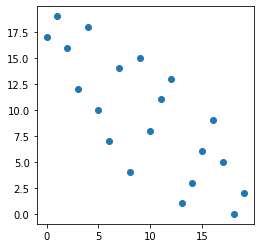

In [42]:
plt.scatter(a[:,0], a[:,1])
plt.axis("scaled")
plt.show()